# 1. Loading templates

In [21]:
%load_ext autoreload
%autoreload 2

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import joblib
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# load workspace
workspace_file = '2d_2channels_workspace_3_0.json'
#results = 'results_3.yaml'

with open(workspace_file, encoding="utf-8") as ws_file:
    ws = json.load(ws_file)
electron_channel = ws['channels'][0]
samples_name = [s['name'] for s in electron_channel['samples']]
templates = np.array([s['data'] for s in electron_channel['samples']])

# 2. Loading data

In [10]:
# Load all generic bbar
training_variables = util.training_variables
variables = util.variables
folder = '../Samples/Generic_MC14ri/MC14ri_bbbar_bengal_e_1'
pfs = glob.glob(f"{folder}/*.parquet")

dfs=[]
for file_path in tqdm(pfs, desc ="Looping over chunks"):
    df = pd.read_parquet(file_path, engine="pyarrow",
                         columns=['__experiment__','__run__','__event__','__production__',
                                  'D_mcPDG', 'e_mcPDG','DecayMode', 
                                  'p_D_l', 'B_D_ReChi2','e_genMotherPDG','B0_mcPDG',
                                  'B0_mcErrors','B0_isContinuumEvent']+variables)
    dfs.append(df)
    del df
df = pd.concat(dfs,ignore_index=True).reset_index()

Looping over chunks:   0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
# Load MVA
import lightgbm as lgb
bst_lgb = lgb.Booster(model_file=f'../BDTs/LightGBM/lgbm_multiclass.txt')

pred = bst_lgb.predict(df[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out = pd.DataFrame(pred, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb = pd.concat([df, lgb_out], axis=1)
df_lgb['largest_prob'] = df_lgb[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred, df, lgb_out

# Apply MVA cut and BCS
cut='signal_prob==largest_prob and signal_prob>0.8'
df_cut=df_lgb.query(cut)
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df, samples=util.get_dataframe_samples(df_bestSelected)
# remove bkg components, will be included back later
df.drop(df[df['mode'].isin(['bkg_continuum','bkg_fakeDTC','bkg_fakeB','bkg_others'])].index, inplace=True)
del df_bestSelected,df_cut,df_lgb

In [12]:
# construct the 2d fitting pattern
xedges = np.linspace(-2, 10, 48) # -7.5 for weMiss2, -2 for weMiss3, -2.5 for weMiss4
yedges = np.linspace(0.4, 4.6, 42)
variable_x = 'B0_CMS3_weMissM2'
variable_y = 'p_D_l'

# drop components for testing
#df_test = df.drop(df[df['mode'].isin([r'$D\tau\nu$',r'$D^\ast\tau\nu$',r'$D^{\ast\ast}\tau\nu$'])].index)
df_test=df
(counts, xedges, yedges) = np.histogram2d(df_test[variable_x], 
                                          df_test[variable_y],
                                          bins=[xedges, yedges])
counts = counts.T

In [13]:
df_test.query(cut)['mode'].value_counts()

$D\ell\nu$               143954
$D^\ast\ell\nu$           95202
$D^{\ast\ast}\ell\nu$     60020
$D\tau\nu$                 8707
$D^\ast\tau\nu$            4314
$D^{\ast\ast}\tau\nu$      2575
Name: mode, dtype: int64

In [19]:
# # Inititalize the template json file
# workspace_file = f'test_data.json'
# xedges = np.linspace(-2, 10, 48) # -7.5 for weMiss2, -2 for weMiss3, -2.5 for weMiss4
# yedges = np.linspace(0.4, 4.6, 42)
# variable_x = 'B0_CMS3_weMissM2'
# variable_y = 'p_D_l'

# i = 0
# for name, df in samples.items():
#     if name in ['bkg_continuum','bkg_fakeDTC','bkg_fakeB','bkg_others']:
#         continue
        
#     (counts, xedges, yedges) = np.histogram2d(df[variable_x], 
#                                               df[variable_y],
#                                               bins=[xedges, yedges])
#     counts = counts.T

#     print(f'After BCS {name=}, size = {np.sum(counts)}')  

#     with open(workspace_file, 'r+') as f:
#         data = json.load(f)
#         data['channels'][0]['samples'][i]['name'] = name
#         data['channels'][0]['samples'][i]['data'] = counts.ravel().tolist()
#         # counts.ravel()/.reshape(-1) returns a view, counts.flatten() returns a copy (slower)
#         f.seek(0)        # <--- should reset file position to the beginning.
#         json.dump(data, f, indent=4)
#         f.truncate()     # remove remaining part

#     i += 1

After BCS name='$D\\tau\\nu$', size = 8707.0
After BCS name='$D^\\ast\\tau\\nu$', size = 4314.0
After BCS name='$D\\ell\\nu$', size = 143929.0
After BCS name='$D^\\ast\\ell\\nu$', size = 95192.0
After BCS name='$D^{\\ast\\ast}\\tau\\nu$', size = 2575.0
After BCS name='$D^{\\ast\\ast}\\ell\\nu$', size = 60019.0


In [9]:
# NumberOfEvents = {'small_pDl':{},'large_pDl':{}}
# for name, sample in samples.items():
#     if name in ['bkg_continuum','bkg_fakeDTC','bkg_fakeB','bkg_others']:
#         continue
#     NumberOfEvents['small_pDl'][name]=len(sample.query('p_D_l<2.5'))
#     NumberOfEvents['large_pDl'][name]=len(sample.query('p_D_l>2.5'))
# NumberOfEvents


## counts.shape=(41,47), the first dimension is p_D_l, counts_small_pDl.shape=(20,47)
# counts_small_pDl = counts[:p_D_l_slice_index[0]]
# counts_large_pDl = counts[p_D_l_slice_index[0]:]

# indices_non_zero_small_pDl = np.where(counts_small_pDl != 0)
# indices_non_zero_large_pDl = np.where(counts_large_pDl != 0)
# data_small_pDl = counts_small_pDl[indices_non_zero_small_pDl]
# data_large_pDl = counts_large_pDl[indices_non_zero_large_pDl]
# templates_small_pDl = [t.reshape(counts.shape)[:p_D_l_slice_index[0]][indices_non_zero_small_pDl] for t in templates]
# templates_large_pDl = [t.reshape(counts.shape)[p_D_l_slice_index[0]:][indices_non_zero_large_pDl] for t in templates]

# templates_small_pDl_2d = [t.reshape(counts.shape)[:p_D_l_slice_index[0]] for t in templates]
# templates_large_pDl_2d = [t.reshape(counts.shape)[p_D_l_slice_index[0]:] for t in templates]

# data_small_pDl_2d = counts[:p_D_l_slice_index[0]]
# data_large_pDl_2d = counts[p_D_l_slice_index[0]:]

In [23]:
# load testing workspace
workspace_file_test = 'templates_subset1.json' # 'templates_subset1.json'
rng = np.random.default_rng(0)

with open(workspace_file_test, encoding="utf-8") as ws_file:
    ws_test = json.load(ws_file)
electron_channel_test = ws_test['channels'][0]
samples_name_test = [s['name'] for s in electron_channel_test['samples']]
test0 = np.array([s['data'] for s in electron_channel_test['samples']])
test1=rng.poisson(test0) # poisson sampling the test templates
counts=np.sum(test1,axis=0).reshape(41,47)

for i, [name,t0,t1] in enumerate(zip(samples_name_test, test0, test1)):
    print(i, name, int(np.sum(t0)), np.sum(t1))

0 $D\tau\nu$ 24776 24861
1 $D^\ast\tau\nu$ 11854 11820
2 $D^{\ast\ast}\tau\nu$ 21646 21469
3 $D\ell\nu$ 30687 30502
4 $D^\ast\ell\nu$ 20251 20359
5 $D^{\ast\ast}\ell\nu$ 14806 14728


In [52]:
# # 2d templates and data
# xedges = np.linspace(-2, 10, 48) # -7.5 for weMiss2, -2 for weMiss3, -2.5 for weMiss4
# yedges = np.linspace(0.4, 4.6, 42)
# temp = [i.reshape(41,47) for i in templates]
# # data = counts.ravel().to_list()
# data = counts
# init_yields = [3000]*6

# 3. Fitting with iminuit

In [42]:
from iminuit import Minuit
from iminuit.cost import poisson_chi2, Template
from IPython.display import display

indices_non_zero = np.where(np.sum(templates,axis=0).reshape(41,47) != 0)
temp = [i.reshape(41,47)[indices_non_zero] for i in templates]
# data = counts.ravel().to_list()
data = counts[indices_non_zero]
edges = np.linspace(0, len(data), len(data)+1)
init_yields = [3000]*6

# for plotting projections
templates_2d = [t.reshape(counts.shape) for t in templates]
data_2d = counts

In [43]:
# fit in 2 steps
# split templates and data at p_D_l==2.5
xedges = np.linspace(-2, 10, 48) # -7.5 for weMiss2, -2 for weMiss3, -2.5 for weMiss4
yedges = np.linspace(0.4, 4.6, 42)

pDl_split = 1
mm2_split = 1.6
pDl_split_index, = np.asarray(np.isclose(yedges,pDl_split,atol=0.1)).nonzero()
mm2_split_index, = np.asarray(np.isclose(xedges,mm2_split,atol=0.1)).nonzero()

# create a boolean array as a mask for fitting
mask_2d = np.zeros((41,47), dtype=bool)
mask_2d[pDl_split_index[0]:,:mm2_split_index[0]] = True # select the large pDl and small mm2
mask_1d = mask_2d[indices_non_zero]

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 381.8 (χ²/ndof = 1.3)      │              Nfcn = 243              │
│ EDM = 2.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name                  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $D\tau\nu$            │    0.0    │    0.1    │            │            │    0    │         │  yes  │
│ 1 │ $D^\ast\tau\nu$       │    0.0    │    0.1    │            │            │    0    │         │  yes  │
│ 2 │ $D^{\ast\ast}\tau\nu$ │    0.0    │    0.1    │            │            │    0    │         │  yes  │
│ 3 │ $D\ell\nu$            │  29.6e3   │   0.4e3   │            │            │    0    │         │       │
│ 4 │ $D^\ast\ell\nu$       │  21.1e3   │   0.6e3   │            │            │    0    │         │       │
│ 5 │ $D^{\ast\ast}\ell\nu$ │  26.9e3   │   1.0e3   │            │            │    0    │         │       │
└───┴───────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                       │            $D\tau\nu$       $D^\ast\tau\nu$ $D^{\ast\ast}\tau\nu$            $D\ell\nu$       $D^\ast\ell\nu$ $D^{\ast\ast}\ell\nu$ │
├───────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            $D\tau\nu$ │                     0                     0                     0                     0                     0                     0 │
│       $D^\ast\tau\nu$ │                     0                     0                     0                     0                     0                     0 │
│ $D^{\ast\ast}\tau\nu$ │                     0                     0                     0                     0                     0                     0 │
│            $D\ell\nu$ │                     0                     0                     0               1.3e+05               -0.14e6                0.10e6 │
│       $D^\ast\ell\nu$ │                     0                     0                     0               -0.14e6              4.18e+05                -0.5e6 │
│ $D^{\ast\ast}\ell\nu$ │                     0                     0                     0                0.10e6                -0.5e6              9.49e+05 │
└───────────────────────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

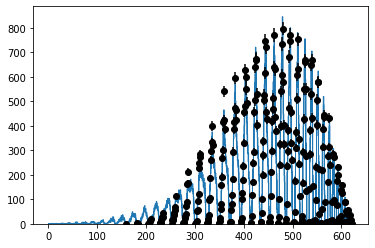

In [51]:
c0 = Template(data, edges, temp, method="da")
# we set the signal amplitude to zero and fix all signal yields
m0 = Minuit(c0, 0,0,0,30000,20000,15000, name=samples_name)

m0.limits = (0, None)
m0.fixed[r'$D\tau\nu$',r'$D^\ast\tau\nu$',r'$D^{\ast\ast}\tau\nu$'] = True

# we temporarily mask out the signal region
c0.mask = mask_1d

m0.simplex().migrad(ncall=1000000)
m0.hesse()
#m0.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 424.7 (χ²/ndof = 1.3)      │              Nfcn = 588              │
│ EDM = 2.28e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name                  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $D\tau\nu$            │   9.4e3   │   1.2e3   │   -1.2e3   │   1.2e3    │    0    │         │       │
│ 1 │ $D^\ast\tau\nu$       │   3.7e3   │   1.9e3   │   -1.7e3   │   2.2e3    │    0    │         │       │
│ 2 │ $D^{\ast\ast}\tau\nu$ │  36.5e3   │   1.6e3   │   -1.7e3   │   1.5e3    │    0    │         │       │
│ 3 │ $D\ell\nu$            │  29.6e3   │   0.4e3   │            │            │    0    │         │  yes  │
│ 4 │ $D^\ast\ell\nu$       │  21.1e3   │   0.6e3   │            │            │    0    │         │  yes  │
│ 5 │ $D^{\ast\ast}\ell\nu$ │  26.9e3   │   1.0e3   │            │            │    0    │         │  yes  │
└───┴───────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │      $D\tau\nu$       │    $D^\ast\tau\nu$    │ $D^{\ast\ast}\tau\nu$ │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -1.2e3   │   1.2e3   │  -1.7e3   │   2.2e3   │  -1.7e3   │   1.5e3   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                       │            $D\tau\nu$       $D^\ast\tau\nu$ $D^{\ast\ast}\tau\nu$            $D\ell\nu$       $D^\ast\ell\nu$ $D^{\ast\ast}\ell\nu$ │
├───────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            $D\tau\nu$ │              1.37e+06                -1.1e6                -0.1e6                     0                     0                     0 │
│       $D^\ast\tau\nu$ │                -1.1e6              3.73e+06                -2.6e6                   0e6                   0e6                   0e6 │
│ $D^{\ast\ast}\tau\nu$ │                -0.1e6                -2.6e6              2.62e+06                     0                     0                     0 │
│            $D\ell\nu$ │                     0                   0e6                     0                     0                     0                     0 │
│       $D^\ast\ell\nu$ │                     0                   0e6                     0                     0          

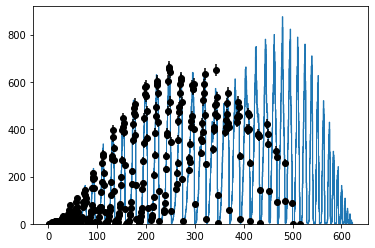

In [52]:
c0.mask = None # remove mask
m0.fixed = False # release all parameters
m0.fixed[r'$D\ell\nu$',r'$D^\ast\ell\nu$',r'$D^{\ast\ast}\ell\nu$'] = True # fix normalization amplitude
m0.values[r'$D\tau\nu$',r'$D^\ast\tau\nu$',r'$D^{\ast\ast}\tau\nu$'] = 10000 # do not start at the limit
# temporarily mask out the norm region
c0.mask = ~mask_1d
m0.simplex().migrad()
m0.hesse()
m0.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 316 (χ²/ndof = 1.0)        │             Nfcn = 1485              │
│ EDM = 4.91e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name                  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $D\tau\nu$            │  24.1e3   │   1.8e3   │            │            │    0    │         │       │
│ 1 │ $D^\ast\tau\nu$       │  10.3e3   │   2.8e3   │            │            │    0    │         │       │
│ 2 │ $D^{\ast\ast}\tau\nu$ │  23.5e3   │   2.3e3   │            │            │    0    │         │       │
│ 3 │ $D\ell\nu$            │  0.11e6   │  0.10e6   │            │            │    0    │         │       │
│ 4 │ $D^\ast\ell\nu$       │  18.5e3   │   3.2e3   │            │            │    0    │         │       │
│ 5 │ $D^{\ast\ast}\ell\nu$ │  14.4e3   │   1.7e3   │            │            │    0    │         │       │
└───┴───────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                       │            $D\tau\nu$       $D^\ast\tau\nu$ $D^{\ast\ast}\tau\nu$            $D\ell\nu$       $D^\ast\ell\nu$ $D^{\ast\ast}\ell\nu$ │
├───────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            $D\tau\nu$ │              3.38e+06                -1.8e6                -0.4e6               -48.3e6                 1.7e6                -1.1e6 │
│       $D^\ast\tau\nu$ │                -1.8e6              7.68e+06                  -6e6                 131e6                  -3e6                -1.8e6 │
│ $D^{\ast\ast}\tau\nu$ │                -0.4e6                  -6e6              5.06e+06                 -79e6                   2e6                 1.9e6 │
│            $D\ell\nu$ │               -48.3e6                 131e6                 -79e6               1.4e+10              -0.318e9              -143.1e6 │
│       $D^\ast\ell\nu$ │                 1.7e6                  -3e6                   2e6              -0.318e9                 1e+07                 2.3e6 │
│ $D^{\ast\ast}\ell\nu$ │                -1.1e6                -1.8e6                 1.9e6              -143.1e6                 2.3e6              2.91e+06 │
└───────────────────────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

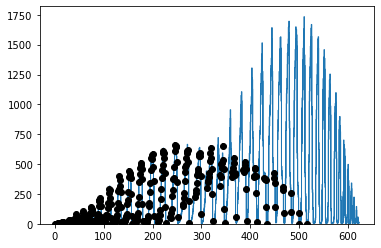

In [61]:
m0.fixed = None
m0.simplex().migrad()

In [ ]:
m0.draw_mnmatrix(figsize=(16,16));

## Barlow-Beeston method

In [34]:
class BB:
    def __init__(self, data, temp):
        # data, template are input argument of the class itself
        self.data = data, temp

    def __call__(self, par):
        # get number of bins and components from data, template
        data, temp = self.data
        bins = len(data)
        nComp = temp.shape[0]
        # formate fitting parameters
        yields = par[:nComp]
        nuisances = par[nComp:]
        temp_nuisances = [nuisances[x:x+bins] for x in np.arange(nComp)*bins]
        # initialize cost function calculation
        fitted_total = 0 # fitted count at each bin
        cost = 0
        # calculate the cost function
        for y, t_nui, i in zip(yields, temp_nuisances, range(len(yields))):
            fitted_total += y * t_nui / np.sum(t_nui)
            cost += poisson_chi2(temp[i], t_nui)
        cost += poisson_chi2(data, fitted_total)
        return cost

    @property
    def ndata(self):
        data, temp = self.data
        return np.prod(data.shape) + np.prod(temp.shape)
    
    def errordef(self):
        return Minuit.LEAST_SQUARES

In [ ]:
m1 = Minuit(BB(data, temp), np.concatenate([init_yields, np.concatenate(temp)]))
m1.limits = (0, None)
m1.migrad(ncall=100000)
m1.hesse()

## Barlow-Beeston-Lite method

In [ ]:
# 2d templates and data
c2 = Template(data, [yedges,xedges], temp, method="da")
m2 = Minuit(c2, *init_yields, name=samples_name)
m2.limits = (0, None)
m2.simplex().migrad()
m2.hesse()
#m2.minos()

In [ ]:
# scipy minimizer

plt.figure(figsize=(16,8))
plt.title('scipy minimizer')
from scipy.optimize import NonlinearConstraint
c3 = Template(data, xedge, temp, method="da") # 'jsc', 'asy'
m3 = Minuit(c3, *init_yields, name=samples_name)
m3.limits = (None, None)
m3.scipy(constraints=NonlinearConstraint(lambda *args: c3.prediction(args)[0], 0, np.inf))
m3.hesse()
#m3.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 594 (χ²/ndof = 1.0)        │              Nfcn = 871              │
│ EDM = 3.45e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name                  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $D\tau\nu$            │  24.7e3   │   1.6e3   │   -1.6e3   │   1.6e3    │    0    │         │       │
│ 1 │ $D^\ast\tau\nu$       │   8.6e3   │   2.3e3   │   -2.3e3   │   2.4e3    │    0    │         │       │
│ 2 │ $D^{\ast\ast}\tau\nu$ │  24.5e3   │   2.0e3   │   -2.0e3   │   2.0e3    │    0    │         │       │
│ 3 │ $D\ell\nu$            │  30.59e3  │  0.35e3   │  -0.35e3   │   0.35e3   │    0    │         │       │
│ 4 │ $D^\ast\ell\nu$       │  20.2e3   │   0.5e3   │   -0.5e3   │   0.5e3    │    0    │         │       │
│ 5 │ $D^{\ast\ast}\ell\nu$ │  15.1e3   │   0.9e3   │   -0.9e3   │   0.9e3    │    0    │         │       │
└───┴───────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │      $D\tau\nu$       │    $D^\ast\tau\nu$    │ $D^{\ast\ast}\tau\nu$ │      $D\ell\nu$       │    $D^\ast\ell\nu$    │ $D^{\ast\ast}\ell\nu$ │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -1.6e3   │   1.6e3   │  -2.3e3   │   2.4e3   │   -2e3    │    2e3    │  -0.35e3  │  0.35e3   │  -0.5e3   │   0.5e3   │  -0.9e3   │   0.9e3   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                       │            $D\tau\nu$       $D^\ast\tau\nu$ $D^{\ast\ast}\tau\nu$            $D\ell\nu$       $D^\ast\ell\nu$ $D^{\ast\ast}\ell\nu$ │
├───────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            $D\tau\nu$ │              2.51e+06                -1.3e6                -0.4e6               -0.03e6  

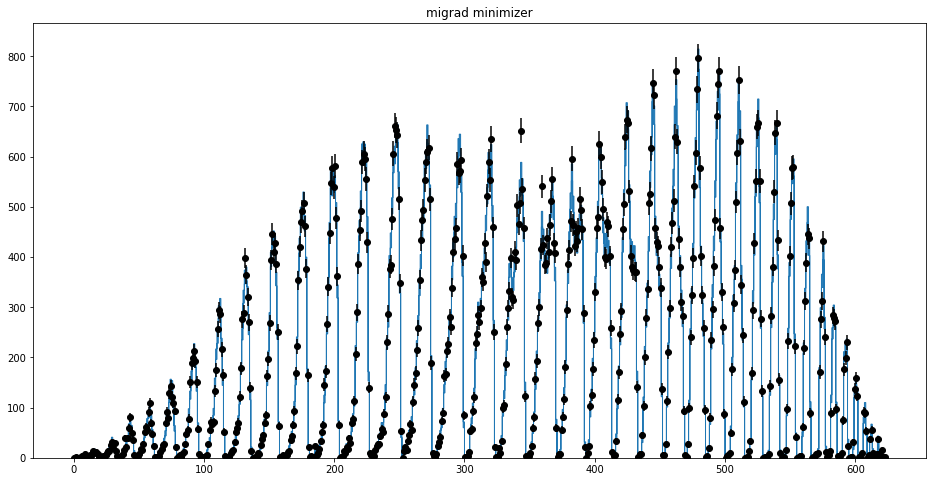

In [40]:
# migrad minimizer

plt.figure(figsize=(16,8))
plt.title('migrad minimizer')
c4 = Template(data, xedge, temp, method="da") # 'jsc', 'asy'
m4 = Minuit(c4, *init_yields, name=samples_name)
m4.limits = (0, None)
m4.simplex().migrad()
m4.hesse()
m4.minos()

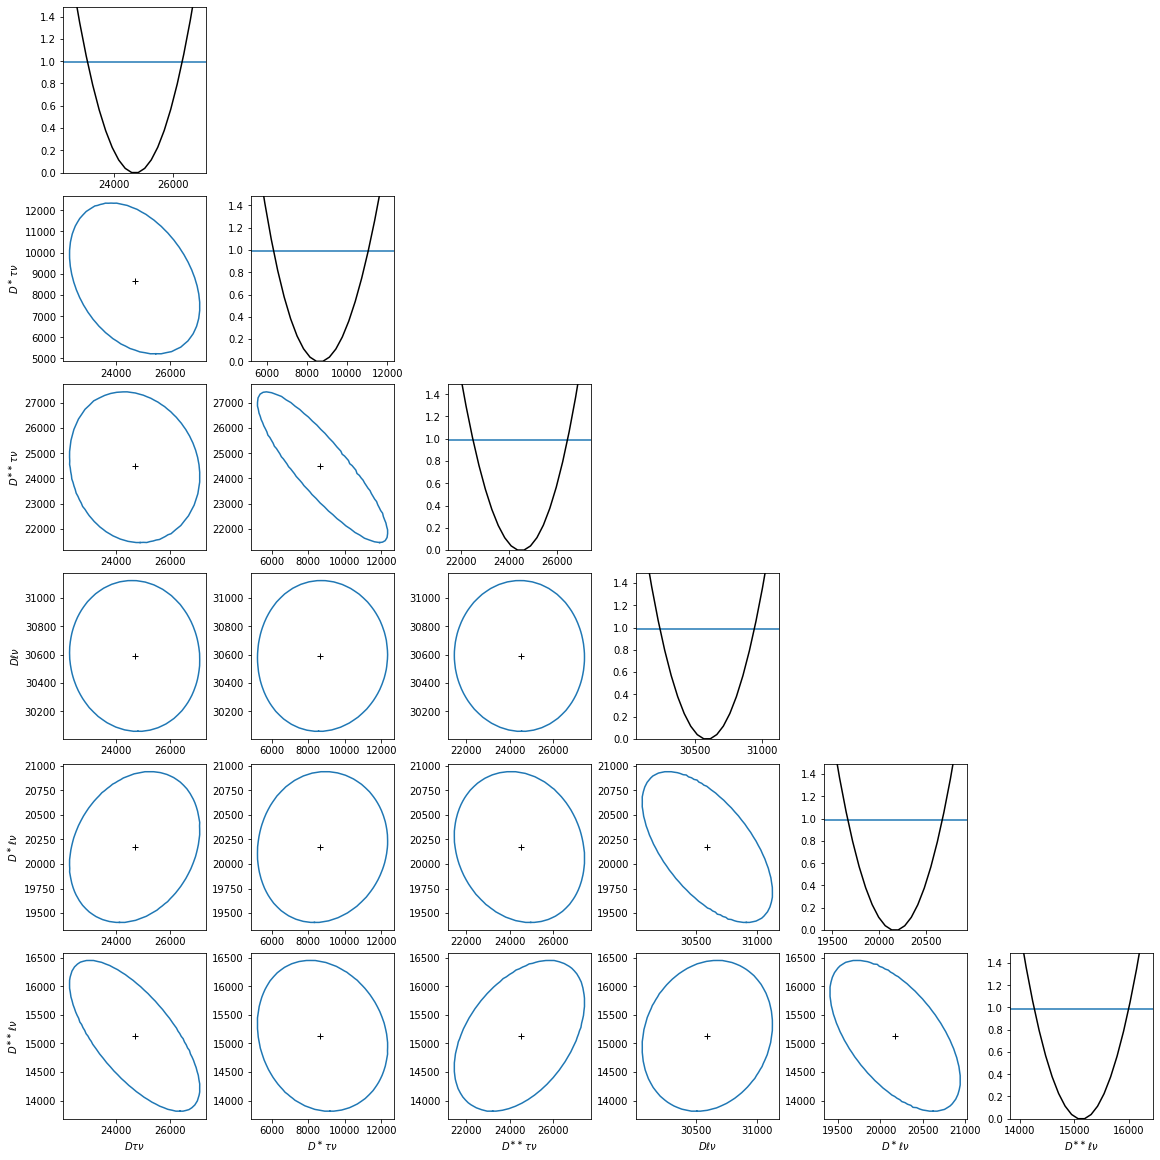

In [41]:
m4.draw_mnmatrix(figsize=(16,16));


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMet

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

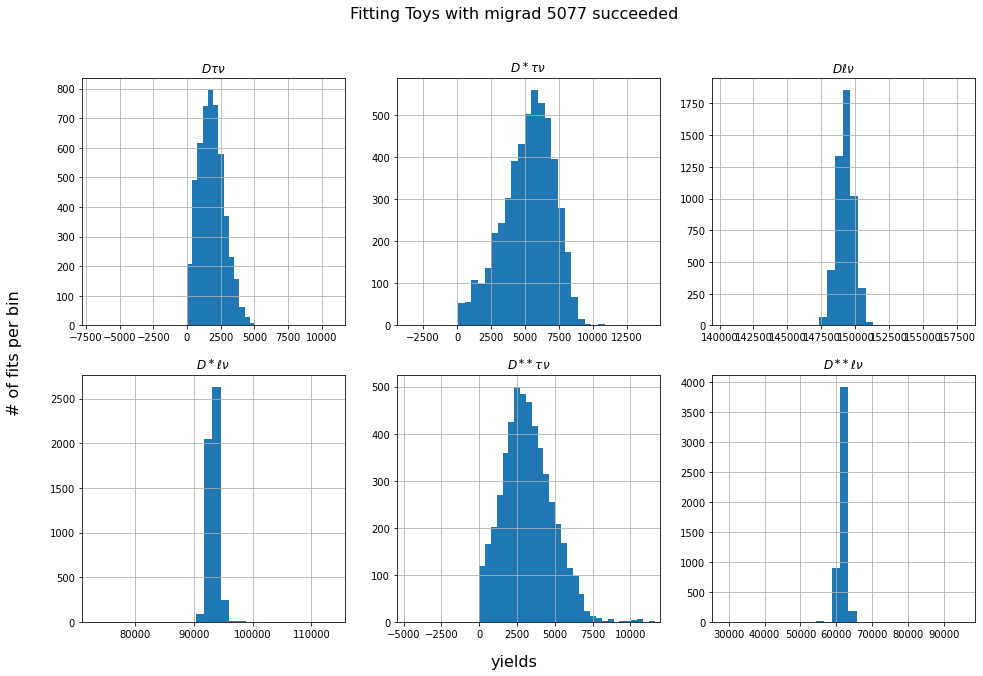


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E Variable


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableM

In [15]:
# import warnings
# # suppress warning messages from iminuit
# warnings.filterwarnings("ignore", message="E VariableMetricBuilder Initial matrix not pos.def.")

@joblib.delayed
def compute_toys(itry,init_yields):
    rng = np.random.default_rng(itry)
    toy = rng.poisson(data)
    cost = Template(toy, xedge, temp, method="da")
    m = Minuit(cost, *init_yields, name=samples_name)
    m.limits = (0, None)
    m.migrad();
    return list(m.values) if m.valid else None

# run 1000 toys
ntoys=20000
toys_migrad = joblib.Parallel(-1)(compute_toys(i,init_yields) for i in range(ntoys))
toys_migrad = [v for v in toys_migrad if v is not None]
# save successful fits to a df
df_toys = pd.DataFrame(toys_migrad,columns=samples_name).round(0)


fig,axs =plt.subplots(2,3,figsize=(16,10))
fig.suptitle(f'Fitting Toys with migrad {len(df_toys)} succeeded',fontsize=16)
fig.supylabel('# of fits per bin',x=0.06,fontsize=16)
fig.supxlabel(f'yields', y=0.06,fontsize=16)
i=0
j=0
for col in df_toys.columns:
    comp=df_toys[col]
    comp_filtered=comp.loc[(comp>comp.mean()-5*comp.std())&(comp<comp.mean()+5*comp.std())]
    axs[i,j].hist(comp_filtered,label=col,bins=30)
    axs[i,j].grid()
    axs[i,j].set_title(col)
    axs[i,j].set_xlim([comp.mean()-5*comp.std(),comp.mean()+5*comp.std()])
    j+=1
    if j==3:
        i+=1
        j=0

In [109]:
def calculate_R(m):
    tau_e_BF = 0.17
    eff_D_tau_nu = 12194/50000
    #eff_D_tau_nu_err = eff_D_tau_nu*np.sqrt(1/12194 + 1/50000)
    eff_D_l_nu = 14108/50000
    #eff_D_l_nu_err = eff_D_l_nu*np.sqrt(1/14108 + 1/50000)
    R_D = m.values[r'$D\tau\nu$']/m.values[r'$D\ell\nu$']/tau_e_BF * eff_D_l_nu/eff_D_tau_nu
    R_D_err = R_D*np.sqrt( (m.errors[r'$D\tau\nu$']/m.values[r'$D\tau\nu$'])**2 + (m.errors[r'$D\ell\nu$']/m.values[r'$D\ell\nu$'])**2 + 1/12194 + 1/50000 + 1/14108 + 1/50000)

    eff_Dst_tau_nu = 2260/10000
    eff_Dst_l_nu = 2466/10000
    R_Dst = m.values[r'$D^\ast\tau\nu$']/m.values[r'$D^\ast\ell\nu$']/tau_e_BF * eff_Dst_l_nu/eff_Dst_tau_nu
    R_Dst_err = R_Dst*np.sqrt( (m.errors[r'$D^\ast\tau\nu$']/m.values[r'$D^\ast\tau\nu$'])**2 + (m.errors[r'$D^\ast\ell\nu$']/m.values[r'$D^\ast\ell\nu$'])**2 + 1/2260 + 1/10000 + 1/2466 + 1/10000)

    print(f'{R_D = :.3f} ± {R_D_err:.3f}')
    print(f'{R_Dst = :.3f} ± {R_Dst_err:.3f}')
    
calculate_R(m2)

R_D = 0.291 ± 0.042
R_Dst = 0.226 ± 0.049


In [112]:
calculate_R(m4)

R_D = 0.306 ± 0.041
R_Dst = 0.215 ± 0.054


# Plot the fitting results

## Plot with mplhep or plt.bar()

In [173]:
xedges = np.linspace(-2, 10, 48) # -7.5 for weMiss2, -2 for weMiss3, -2.5 for weMiss4
yedges = np.linspace(0.4, 4.6, 42)

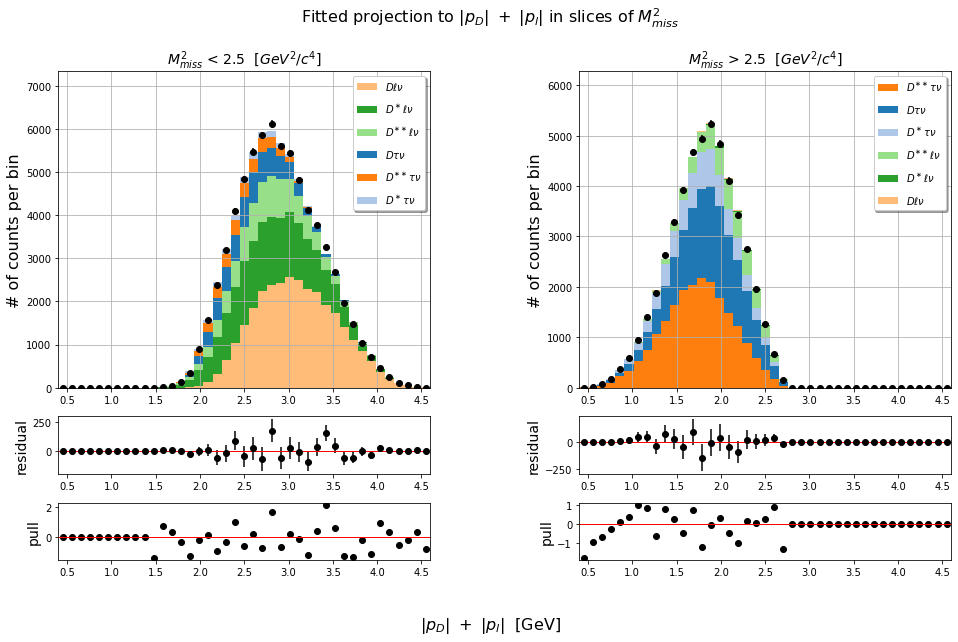

In [68]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[2.5,1],direction='p_D_l',plot_with='pltbar')

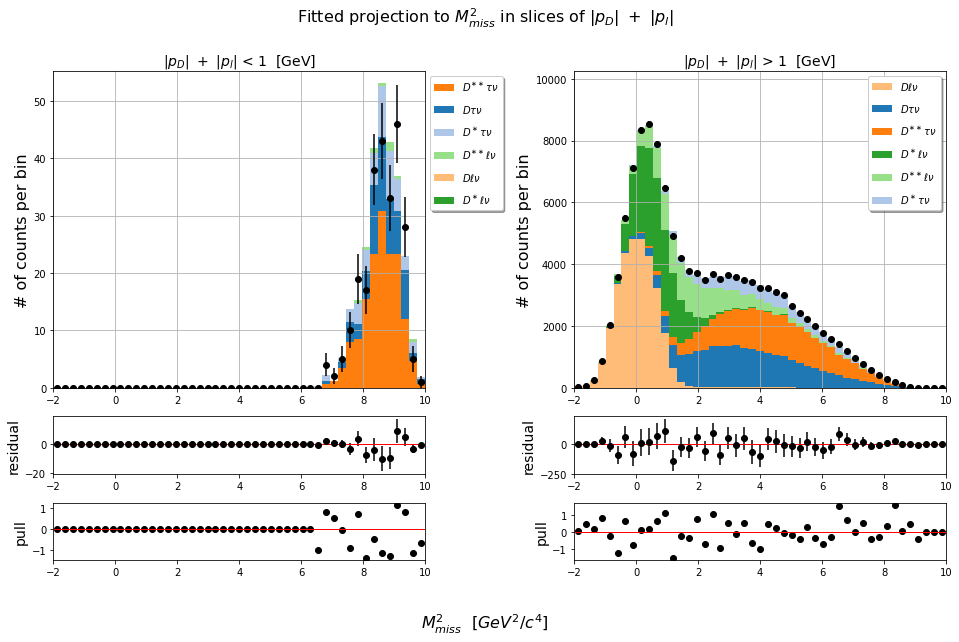

In [69]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[2.5,1],direction='mm2',plot_with='pltbar')

In [215]:
util.ply_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[1.6,1],direction='mm2')